# Randomized Kaczmarz algorithm with conjugate symmetry --- Sequential solver

In [1]:
import os, math, time
import numpy as np
import numpy.matlib
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import h5py
plt.style.use('default')

from harmonic_helper import *

In [2]:
fname = "3D_face_k_60.mat"
#fname = "half_stone_N_max_26.mat"
#fname = "left_hemisphere_brain_k_60.mat"

v, D_mat = HarmIO.read_hdf5(fname)
D = D_mat.T
V = v.T

_m, _n = D.shape
print("System size is {} rows and {} columns for {} degrees".format(_m, _n, int(np.sqrt(_n)-1)))

System size is 21238 rows and 3844 columns for 61 degrees



Solver's time: 1.020641275246938 min


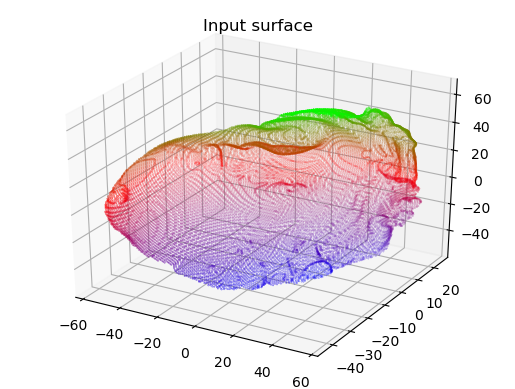

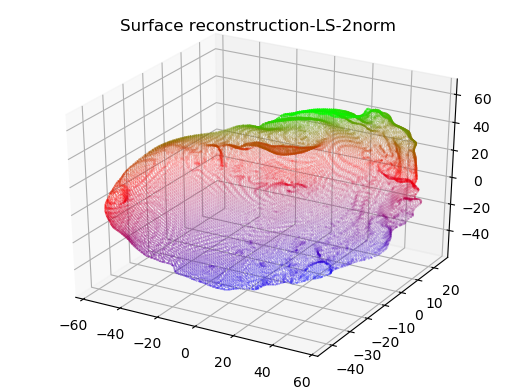

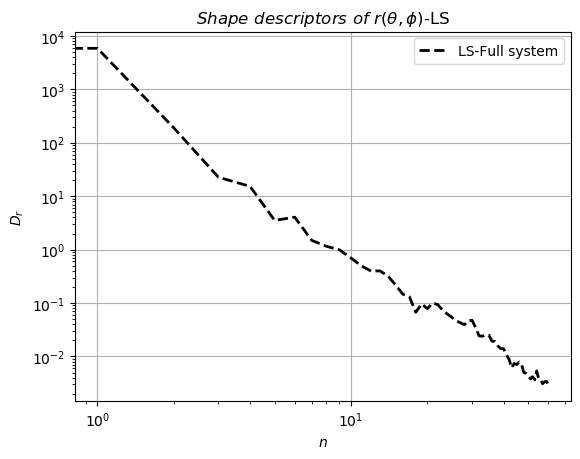

In [3]:
# The fastest parallel Least-squares solver (uses all the cores!)
coefs_LS = L2Solvers.solve_2_norm(D, V)

ax = plt.axes(projection='3d')
ax.scatter3D(V[:, 1], V[:, 2], V[:, 0], c=V[:, 0], s=0.1, cmap='brg');
plt.title("Input surface")
plt.show()

V1 = np.real(D @ coefs_LS)
ax = plt.axes(projection='3d')
ax.scatter3D(V1[:, 1], V1[:, 2], V1[:, 0], c=V1[:, 0], s=0.1, cmap='brg');
plt.title("Surface reconstruction-LS-2norm")
plt.show()

Dx_LS, Dy_LS, Dz_LS = shape_descriptors(coefs_LS)
Dr_LS = Dx_LS + Dy_LS + Dz_LS
plt.figure()
plt.loglog(np.arange(len(Dr_LS)), Dr_LS, '--k', linewidth=2, markersize=10, label='LS-Full system')
plt.ylabel(r'$D_r$')
plt.xlabel(r'$n$')
plt.grid()
plt.legend()
plt.title(r'$Shape~descriptors~of~r(\theta, \phi)$-LS');

In [4]:
max_iter = 4
relax = 0.3

t1 = time.time()
x_RK_solver = Kaczmarz_solver(D, V[:, 0], x0=[], iterations = max_iter, relaxation = relax)
y_RK_solver = Kaczmarz_solver(D, V[:, 1], x0=[], iterations = max_iter, relaxation = relax)
z_RK_solver = Kaczmarz_solver(D, V[:, 2], x0=[], iterations = max_iter, relaxation = relax)

coef_x_kz = x_RK_solver.solve_Kaczmarz_conjugate_sym()
coef_y_kz = y_RK_solver.solve_Kaczmarz_conjugate_sym()
coef_z_kz = z_RK_solver.solve_Kaczmarz_conjugate_sym()
coefs_RK = np.array([coef_x_kz, coef_y_kz, coef_z_kz]).T

print("Overall processing time is {} min".format((time.time()-t1)/60))


Solver's time: 6.191279888153076 sec

Solver's time: 5.665259838104248 sec

Solver's time: 5.872871160507202 sec
Overall processing time is 0.3861948370933533 min


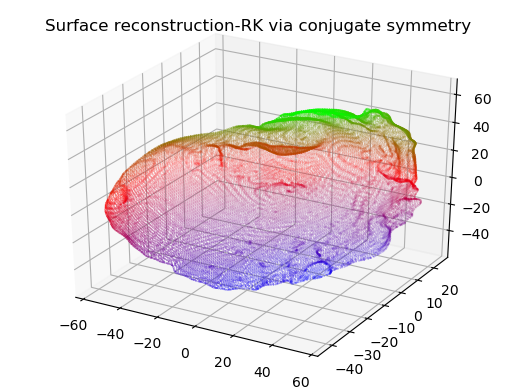

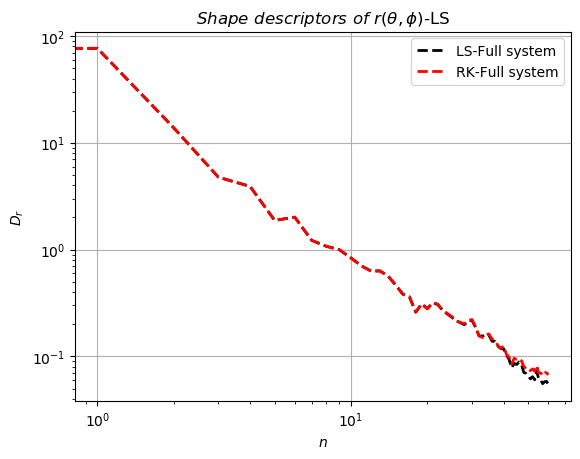

In [5]:
V2 = np.real(D @ coefs_RK)
ax = plt.axes(projection='3d')
ax.scatter3D(V2[:, 1], V2[:, 2], V2[:, 0], c=V2[:, 0], s=0.1, cmap='brg');
plt.title("Surface reconstruction-RK via conjugate symmetry")
plt.show()

Dx_RK, Dy_RK, Dz_RK = shape_descriptors(coefs_RK)
Dr_RK = Dx_RK + Dy_RK + Dz_RK

plt.figure()
plt.loglog(np.arange(len(Dr_LS)), np.sqrt(Dr_LS), '--k', linewidth=2, markersize=10, label='LS-Full system')
plt.loglog(np.arange(len(Dr_RK)), np.sqrt(Dr_RK), '--r', linewidth=2, markersize=10, label='RK-Full system')
plt.ylabel(r'$D_r$')
plt.xlabel(r'$n$')
plt.grid()
plt.legend()
plt.title(r'$Shape~descriptors~of~r(\theta, \phi)$-LS');

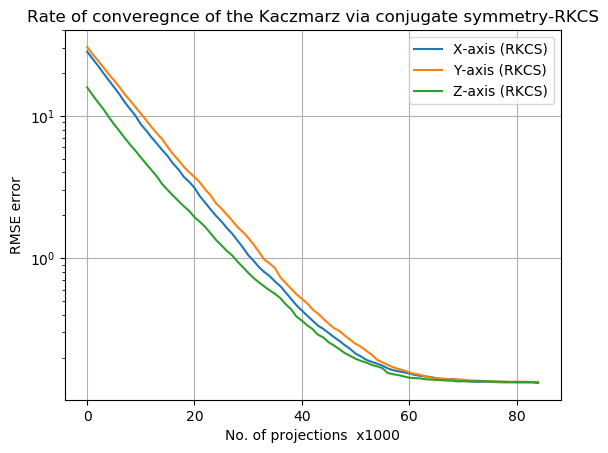

In [6]:
rec_steps = 1000

rec_error_x = x_RK_solver.reconstruct_history(rec_steps = rec_steps)
rec_error_y = y_RK_solver.reconstruct_history(rec_steps = rec_steps)
rec_error_z = z_RK_solver.reconstruct_history(rec_steps = rec_steps)

plt.figure()
plt.semilogy(rec_error_x, label="X-axis (RKCS)")
plt.semilogy(rec_error_y, label="Y-axis (RKCS)")
plt.semilogy(rec_error_z, label="Z-axis (RKCS)")
plt.xlabel("No. of projections  x{}".format(rec_steps))
plt.ylabel("RMSE error")
plt.legend()
plt.grid()
plt.title(r'Rate of converegnce of the Kaczmarz via conjugate symmetry-RKCS')
plt.show();